# Problem Set 7

In [2]:
using Pkg
Pkg.activate(@__DIR__)

# Load packages
using QuantEcon
using QuantEcon: solve
using Parameters: @unpack
using ForwardDiff: gradient, hessian
using FiniteDifferences: grad, central_fdm
using Statistics: mean
using LinearAlgebra: dot, norm
using Plots
using DataFrames
using Binscatters
using Optim
using Optim: optimize, minimizer, f_calls
using TexTables
using LogExpFunctions
using ProgressMeter
using Interpolations
using LaTeXStrings
using DataFrames
using Plots

  Activating project at `/workspaces/PNM-for-Econ-Group-1`


## Problem 1
### Problem 1a

In [3]:
# Model parameters
params = (
    β = 0.95,
    δ = 0.05,
    σ = 2.0,
    ν = 2.0,
    α = 1/3,
    A = 1.0,
    ϕ = 1.0)

# Functions
@unpack β, δ, σ, ν, α, A, ϕ = params
u(c, l) = c^(1-σ)/(1-σ) - ϕ*l^(1+ν)/(1+ν)
f(k, l) = A*k^(α)*l^(1-α)

k_grid = range(1e-6, 10, 50)
l_grid = range(0, 1, 50)

0.0:0.02040816326530612:1.0

In [7]:
# Value function iteration
function vfi(v0, n_iter=1000, tol=1e-6)
    @unpack β, δ, σ, ν, α, A, ϕ = params
    v = copy(v0)
    log_errors_vfi = zeros(n_iter)
    for i in 1:n_iter
        v_new = similar(v)
        for (i_k, k) in enumerate(k_grid)
            max_val = -Inf
            for l in l_grid
                cons = f(k, l) + (1-δ)*k
                for k_p in k_grid
                    if cons >= k_p
                        c = cons - k_p
                        obj_val = u(c, l) + β * v[searchsortedlast(k_grid, k_p)]
                        max_val = max(max_val, obj_val)
                    end
                end
            end
            v_new[i_k] = max_val
        end
        log_errors_vfi[i] = log10(maximum(abs.(v_new .- v)))
        v = v_new
    end
    return v, log_errors_vfi
end

# Initial guess
v0 = ones(length(k_grid))

@time v_star, log_error_vfi = vfi(v0)

function calculate_policy(v_star)
    @unpack β, δ, σ, ν, α, A, ϕ = params
    c_policy = zeros(length(k_grid))
    l_policy = zeros(length(k_grid))
    k_policy = zeros(length(k_grid))
    
    for (i_k, k) in enumerate(k_grid)
        max_val = -Inf
        optimal_c = optimal_l = optimal_k_p = 0
        
        for l in l_grid
            for k_p in k_grid
                c = f(k, l) + (1-δ)*k - k_p  # Define c here
                if c > 0
                    val = u(c, l) + β * v_star[searchsortedlast(k_grid, k_p)]
                    if val > max_val
                        max_val = val
                        optimal_c, optimal_l, optimal_k_p = c, l, k_p
                    end
                end
            end
        end
        
        c_policy[i_k] = optimal_c
        l_policy[i_k] = optimal_l
        k_policy[i_k] = optimal_k_p
    end
    
    return c_policy, l_policy, k_policy
end

 38.309155 seconds (1.48 G allocations: 23.933 GiB, 1.55% gc time, 0.37% compilation time)


calculate_policy (generic function with 1 method)

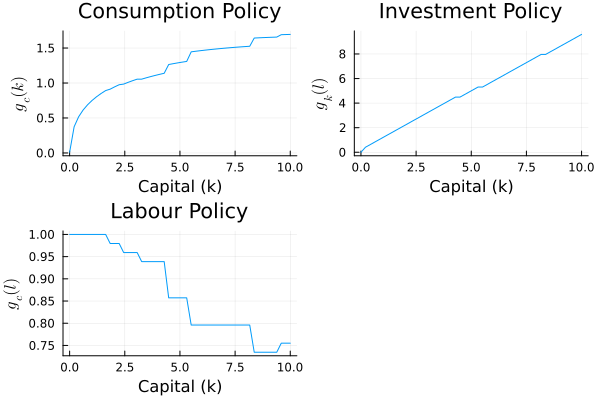

In [8]:
# Plot
c_policy, l_policy, k_policy = calculate_policy(v_star)

consumption_p = plot(k_grid, c_policy, label="Consumption", xlabel="Capital (k)", ylabel="\$g_c(k)\$", title = "Consumption Policy")
labour_p = plot(k_grid, l_policy, label="Labour Supply", xlabel="Capital (k)", ylabel="\$g_c(l)\$", title = "Labour Policy")
investment_p = plot(k_grid, k_policy, label="Investment", xlabel="Capital (k)", ylabel="\$g_k(l)\$", title = "Investment Policy")

plot(consumption_p, investment_p, labour_p, legend=false)

### Problem 1b

In [10]:
v0 = ones(length(k_grid))
c_policy_initial = rand(length(k_grid)).*maximum(k_grid)
l_policy_initial = rand(length(k_grid))
k_policy_initial = rand(length(k_grid)).*maximum(k_grid)

function policy_iteration(v0, c_policy_initial, l_policy_initial, k_policy_initial; n_iter=1000, tol=1e-12, policy_steps_vector)
    @unpack β, δ, σ, ν, α, A, ϕ = params
    log_errors_all = Dict()
    
    for policy_steps in policy_steps_vector
        println("------------- $policy_steps policy steps --------------")
        log_errors = zeros(n_iter)
        v = copy(v0)
        c_policy = copy(c_policy_initial)
        l_policy = copy(l_policy_initial)
        k_policy = copy(k_policy_initial)
        
        @time begin
            for i in 1:n_iter
                v_new = similar(v)
                for (i_k, k) in enumerate(k_grid)
                    max_val = -Inf
                    for (i_l, l) in enumerate(l_grid)
                        for k_p in k_grid
                            c = f(k, l) + (1-δ)*k - k_p
                            if c > 0
                                val = u(c, l) + β * v[searchsortedlast(k_grid, k_p)]
                                if val > max_val
                                    max_val = val
                                    c_policy[i_k] = c
                                    l_policy[i_k] = l
                                    k_policy[i_k] = k_p
                                end
                            end
                        end
                    end
                    v_new[i_k] = max_val
                end

                for p_step in 2:policy_steps
                    for (i_k, k) in enumerate(k_grid)
                        max_val = -Inf
                        for (i_l, l) in enumerate(l_grid)
                            for k_p in k_grid
                                c = f(k, l) + (1-δ)*k - k_p
                                if c > 0
                                    val = u(c, l) + β * v_new[searchsortedlast(k_grid, k_p)]
                                    if val > max_val
                                        max_val = val
                                        c_policy[i_k] = c
                                        l_policy[i_k] = l
                                        k_policy[i_k] = k_p
                                    end
                                end
                            end
                        end
                        v_new[i_k] = max_val
                    end
                end

                log_errors[i] = log10(maximum(abs.(v_new .- v)))
                dist = maximum(abs.(v_new .- v))
                v = v_new
                if dist < tol
                    log_errors = log_errors[1:i]
                    println("Converged in $i iterations with error $dist ")
                    break
                end
            end
        end
        log_errors_all[policy_steps] = log_errors
        println("\n")
    end

    return c_policy, l_policy, k_policy, log_errors_all
end

policy_steps_vector = [2, 5, 10]
c_policy, l_policy, k_policy, log_errors_all = policy_iteration(v0, c_policy_initial, l_policy_initial, k_policy_initial; policy_steps_vector=policy_steps_vector)

------------- 2 policy steps --------------
Converged in 321 iterations with error 9.094947017729282e-13 
 45.629958 seconds (1.65 G allocations: 25.877 GiB, 1.33% gc time)


------------- 5 policy steps --------------
Converged in 134 iterations with error 9.094947017729282e-13 
 47.764187 seconds (1.72 G allocations: 27.006 GiB, 1.29% gc time)


------------- 10 policy steps --------------
Converged in 68 iterations with error 1.4210854715202004e-14 
 48.172528 seconds (1.75 G allocations: 27.409 GiB, 1.32% gc time)




([0.009999950000000002, 0.3744702419792123, 0.517295629287988, 0.614438237456386, 0.6896927401169783, 0.7516551917327225, 0.8045330221139875, 0.8507378791625249, 0.8917959796746686, 0.9120223990343677  …  1.525204999419457, 1.642773116150452, 1.64590007132748, 1.6488170670857993, 1.651532180086619, 1.6540530010730894, 1.6563866741828335, 1.690429871888396, 1.692633652923444, 1.6946662773929813], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9795918367346939  …  0.7959183673469388, 0.7346938775510204, 0.7346938775510204, 0.7346938775510204, 0.7346938775510204, 0.7346938775510204, 0.7346938775510204, 0.7551020408163265, 0.7551020408163265, 0.7551020408163265], [1.0e-6, 0.40816422448979595, 0.6122458367346939, 0.8163274489795919, 1.0204090612244898, 1.2244906734693877, 1.4285722857142857, 1.6326538979591836, 1.8367355102040817, 2.0408171224489795  …  7.959183877551021, 7.959183877551021, 8.163265489795918, 8.367347102040815, 8.571428714285714, 8.775510326530613, 8.97959193877551, 9.1836

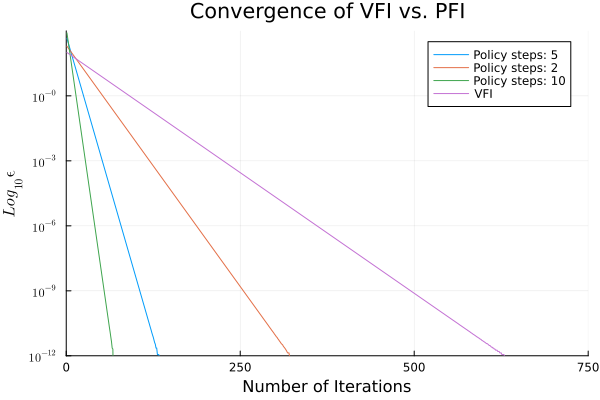

In [12]:
plot(title  = "Convergence of VFI vs. PFI",
    label  = "VFI",
    ylim = (-12, 3),
    xlim = (0, 750),
    xlabel = "Number of Iterations",
    ylabel = raw"$Log_{10} ϵ$",
    legend = :topright)
yticks!([-12, -9, -6, -3, 0], ["\$10^{-12}\$", "\$10^{-9}\$", "\$10^{-6}\$", "\$10^{-3}\$", "\$10^{-0}\$"])
for (policy_steps, log_errors) in log_errors_all
    iterations = 1:length(log_errors)
    plot!(iterations, log_errors, label="Policy steps: $policy_steps")
end
plot!(log_error_vfi, label = "VFI")

### Problem 1c